# Portfolio optimization for the stocks Shell plc, BP plc, Microsoft and Apple using Markowitz Mean Variance Optimization and Expected utility theory methods

Markowitz Mean Variance Optimization

Using the pyfportifolioopt package

In [1]:
#Required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, EfficientFrontier
from pypfopt import objective_functions
from pypfopt import plotting

##Using data from Yahoo finance ; these are prices for the BP plc,SHELL plc, Microsoft 
##and Apple stocks which we convert to returns
import yfinance as yf

##Downloading the data from Yahoo Finance
dta=yf.download ("SHEL BP MSFT AAPL",start="2018-01-01",end="2023-05-14")

#create a dataframe of the four stocks
sh=dta['Adj Close']['SHEL']
bp=dta['Adj Close']['BP']
ms=dta['Adj Close']['MSFT']
ap=dta['Adj Close']['AAPL']
data=pd.DataFrame(sh.values,columns=['SHEL'])  
data['MSFT']=ms.values
data['AAPL']=ap.values
data['BP']=bp.values
data.index=sh.index

#compute asset/stock returns
 
#we use logarithmic returns because they are better computationaly
dta_returns=data.pct_change().apply(lambda x: np.log(1+x))

#  drop all rows containing an NA
Returns=dta_returns.dropna(axis=0,how='any')   
Returns.head(10)


/usr/local/lib/python3.9/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/usr/local/lib/python3.9/dist-packages/pandas/core/arrays/masked.py:59: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


[*********************100%***********************]  4 of 4 completed


,SHEL,MSFT,AAPL,BP
Date,,,,
2018-01-03,0.008051,0.004643,-0.000174,0.011496
2018-01-04,0.004364,0.008763,0.004634,0.003958
2018-01-05,0.002175,0.012322,0.011321,0.001393
2018-01-08,0.000290,0.001020,-0.003721,-0.000464
2018-01-09,-0.004208,-0.000680,-0.000115,-0.004887
2018-01-10,0.003918,-0.004545,-0.000230,0.000700
2018-01-11,0.011521,0.002956,0.005664,0.008588
2018-01-12,0.014781,0.017110,0.010274,0.014682
2018-01-16,-0.012779,-0.014049,-0.005095,-0.033580


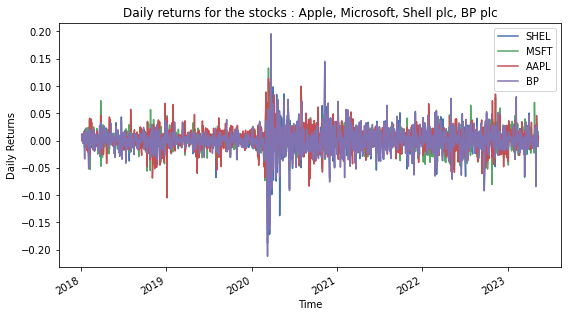

In [2]:
#plotting the returns
Returns.plot(figsize=(9,5))
plt.title('Daily returns for the stocks : Apple, Microsoft, Shell plc, BP plc')
plt.xlabel('Time')
plt.ylabel('Daily Returns')
plt.savefig('Returns.pdf')
plt.show()

In [3]:
##Getting the annual volatilities and annual expected returns of the assets

ann_volatility = data.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(252))
ann_mean=data.resample('Y').last().pct_change().mean()

##Putting the annual voaltilities and returns in a table
assets_statistics = pd.concat([ann_mean, ann_volatility], axis=1) 
assets_statistics.columns = ['Returns', 'Volatility']
print(ann_volatility)
##Getting the latex code
print(assets_statistics.to_latex())

#The table
assets_statistics

SHEL    0.367136
MSFT    0.309723
AAPL    0.329292
BP      0.369698
dtype: float64
\begin{tabular}{lrr}
\toprule
{} &   Returns &  Volatility \\
\midrule
SHEL &  0.080955 &    0.367136 \\
MSFT &  0.307402 &    0.309723 \\
AAPL &  0.425426 &    0.329292 \\
BP   &  0.085126 &    0.369698 \\
\bottomrule
\end{tabular}



<ipython-input-3-a6e480fac84d>:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(assets_statistics.to_latex())


,Returns,Volatility
SHEL,0.080955,0.367136
MSFT,0.307402,0.309723
AAPL,0.425426,0.329292
BP,0.085126,0.369698


In [4]:
#Portfolio optimization using pyportfolioopt

# Calculate expected returns and covariance matrix

##The expected returns matrix
mu=data.resample('Y').last().pct_change().mean()

#The variance-covariance matrix
Sigma=Returns.cov()

#Defining the optimization problem
#The efficient frontier
ef = EfficientFrontier(mu, Sigma)

#optimal weights at minimimum variance
weights = ef.min_volatility()

#The weights array
weights = np.array(list(weights.values()))

#compute portfolio returns
returns_port=Returns@weights

#portfolio mean return 
portfolio_mean_return=weights.T@mu

#portfolio variance and standard deviation
port_var=weights.T@(Sigma@weights)
port_vol=np.sqrt(port_var)

#The results
print("Optimal weights:", weights)
print("Portfolio return:", portfolio_mean_return)
print("Portfolio volatility:", port_vol)






Optimal weights: [0.18101282 0.41398235 0.22838586 0.17661897]
Portfolio return: 0.25410917705769476
Portfolio volatility: 0.0167842473309653


In [8]:
# A table of the optimal weights
weights=pd.Series(weights)
opt_weights = pd.concat([weights], axis=1) 
opt_weights.columns = ['Optimal Weights']
opt_weights.index=assets_statistics.index
opt_weights
#print(opt_weights.to_latex())

,Optimal Weights
SHEL,0.181012
MSFT,0.413982
AAPL,0.228386
BP,0.176619


The sharpe ratio is the ratio of the porfolio return less the risk free rate return and the porfolio risk i.e the standard deviation:

$$
sharpe \,ratio=\frac{\mu_p-rf}{\sigma_p}
$$
where $\mu_p$ is the portfolio mean return, $rf$ is the riskless rate of return and $\sigma_p$ is the portfolio standard deviation.



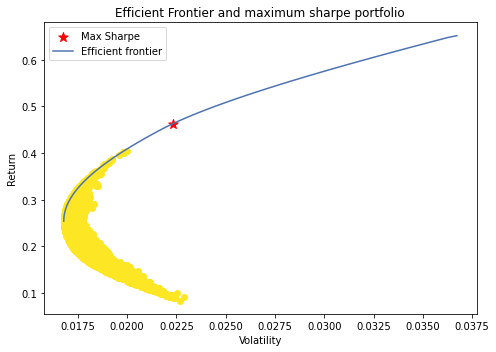

In [6]:
#Plotting the efficient frontier for a maximum sharpe ratio optimization
##We do this by looping over a set number of portfolios

#Number of assets
num_assets = len(data.columns)

#risk free rate
rf=0.001
#generated portfolios
num_portfolios = 10000
ef = EfficientFrontier(mu, Sigma, weight_bounds=(None, None))
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()

# Find the maximum sharpe ratio portfolio 
ef_max_sharpe.max_sharpe()

#The mean and volatility of maximum sharpe portfolio
ret_sharpe, std_sharpe, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_sharpe, ret_sharpe, marker="*", s=100, c="r", label="Max Sharpe")

#generating portfolios and plotting their volatilities and mean returns
for portfolio in range(num_portfolios):

    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    rets =weights.dot(ef.expected_returns)
    var = weights @ ef.cov_matrix @ weights.T
    stds = np.sqrt(var)
    # Annual standard deviation is the volatility
    #stds = sd*np.sqrt(252) 
    sharpes = (rets-rf) / stds
    ax.scatter(stds, rets, marker="o", c=sharpes, cmap="viridis_r")
fig.set_figheight(5)
fig.set_figwidth(7)   
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)    
ax.set_title("Efficient Frontier and maximum sharpe portfolio")
ax.legend()
plt.tight_layout()
plt.savefig('Maximum sharpe portfolio.pdf')
plt.show()

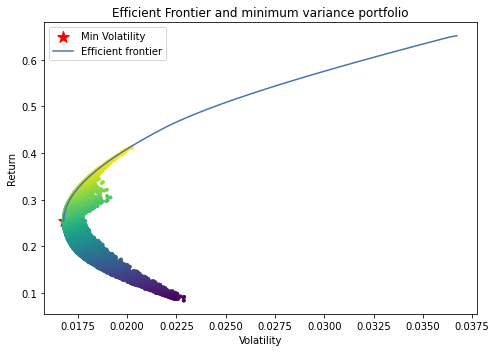

In [9]:

#Plotting the minimium variance frontier
num_assets = len(data.columns)
rf=0.001
num_ports = 10000
ef1 = EfficientFrontier(mu, Sigma, weight_bounds=(None, None))

ef1_min_volatility=ef1.deepcopy()

# Find the minimum volatility portfolio

ef1_min_volatility.min_volatility()

#mean and volatility of minimum volatility portfolio
ret_minvol, std_minvol,_=ef1_min_volatility.portfolio_performance()

# Generate random portfolios
w = np.random.dirichlet(np.ones(ef.n_assets), num_ports)
rets1 = w.dot(ef1.expected_returns)
stds1 = np.sqrt(np.diag(w @ ef1.cov_matrix @ w.T))
sharpes1 = (rets1-rf) / stds1
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(7)
ax.scatter(std_minvol, ret_minvol, marker="*", s=150, c="r", label="Min Volatility")
ax.scatter(stds1, rets1, marker=".", c=sharpes1)
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=False)
ax.set_title("Efficient Frontier and minimum variance portfolio")
ax.legend()
plt.tight_layout()
plt.savefig("Minimum volatility.pdf")
plt.show()

In [10]:
### Alternatively the minimum volatility and maximum sharpe ratio portfolios can be plotted as below

# empty array for portfolio returns
p_ret = [] 
# empty array for portfolio volatility
p_vol = [] 

#  empty array for asset weights
p_weights = [] 


num_assets = len(data.columns)
num_portfolios = 10000


for portfolio in range(num_portfolios):
    
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns =weights.T@mu 
    p_ret.append(returns)
    var = weights.T@(Sigma@weights)
    sd = np.sqrt(var)
    # Annual standard deviation is the volatility
    ann_sd = sd*np.sqrt(252) 
    p_vol.append(ann_sd)

In [15]:
#create a dictionary for returns and volatility 
data1 = {'Returns':p_ret, 'Volatility':p_vol}

#append the weights for the stocks into   the data dictionary
data1 = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(data.columns.tolist()):
    #print(counter, symbol)
    data1[symbol+' weight'] = [w[counter] for w in p_weights]
    
#the portfolios dataframe
portfolios  = pd.DataFrame(data1)
portfolios.head(10)

,Returns,Volatility,SHEL weight,MSFT weight,AAPL weight,BP weight
0,0.276537,0.271410,0.276989,0.177596,0.449871,0.095544
1,0.185566,0.279370,0.132931,0.415214,0.025574,0.426281
2,0.215617,0.271702,0.392506,0.543159,0.033489,0.030845
3,0.184368,0.291579,0.415182,0.114806,0.221732,0.248280
4,0.230470,0.272798,0.066902,0.256397,0.260453,0.416248
5,0.228360,0.268566,0.308629,0.395894,0.166097,0.129379
6,0.259853,0.276943,0.168419,0.065720,0.472586,0.293275
7,0.203503,0.273653,0.076868,0.493562,0.026419,0.403152
8,0.214415,0.271369,0.166513,0.376003,0.136372,0.321112
9,0.198498,0.286845,0.211411,0.119021,0.258003,0.411565


In [16]:
#The minimum variance portfolio

min_vol_portfolio = portfolios.iloc[portfolios['Volatility'].idxmin()]
                               
min_vol_portfolio

Returns        0.255837
Volatility     0.266470
SHEL weight    0.172469
MSFT weight    0.426806
AAPL weight    0.224983
BP weight      0.175742
Name: 4970, dtype: float64

In [17]:
# Finding the optimal portfolio by getting the maximum sharpe ratio portfolio as defined before
#The risk free rate 
rf = 0.001
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns        0.418760
Volatility     0.325040
SHEL weight    0.010110
MSFT weight    0.010565
AAPL weight    0.973636
BP weight      0.005689
Name: 1670, dtype: float64

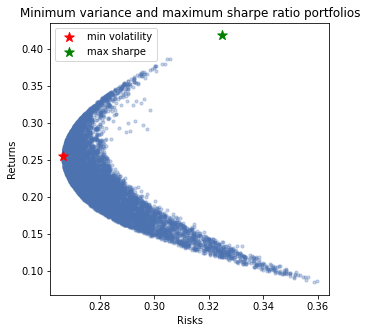

In [19]:
# Plotting minimum variance and optimalrisky portfolios using scatter ()
plt.subplots(figsize=(5, 5))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_portfolio[1], min_vol_portfolio[0], color='r', marker='*', s=100, label='min volatility')
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=100, label='max sharpe')
plt.xlabel('Risks')
plt.ylabel('Returns')
plt.title('Minimum variance and maximum sharpe ratio portfolios')
plt.legend(loc='upper left')
plt.show()

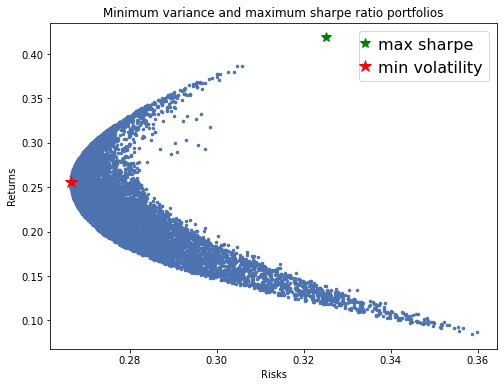

In [21]:
##Altenatively plotting the minimum variance and optimal risky assets using plt.plot()
#creating an array of the volatilities
vol1=np.array(p_vol)

#returns array
ret1=np.array(p_ret)

plt.figure(figsize=(8,6))
#plotting returns against standatd deviation
plt.plot(vol1,ret1,'.',markersize=5)

#The optimal risky portfolio
plt.plot(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*',markersize=10,label='max sharpe')

#The minimum variance portfolio
plt.plot(min_vol_portfolio[1], min_vol_portfolio[0], color='r', marker='*', markersize=12, label='min volatility')
plt.xlabel('Risks')
plt.ylabel('Returns')
plt.title('Minimum variance and maximum sharpe ratio portfolios')
plt.legend(handlelength=0,prop={'size': 16})
plt.savefig('combined portfolios MV.pdf')
plt.show()

Expected utility optimisation using scipy.optimize

In [22]:
#Required packages
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# number of assets
n_assets = len(data.columns)



# Define expected utility function where a quadratic utility function is used
def expected_utility(w, returns, risk_aversion):
    
    expected_return =w.T @ np.mean(returns, axis=0)
    
    variance = w.T @(np.cov(returns.T)@w)
 
    #Change of sign of the function because we need to maximize the expected utility
    utility =-expected_return + (0.5 * risk_aversion * variance) 
    return utility

#initial portfolio weights
w0 = np.ones(n_assets) / n_assets

# risk aversion 
risk_aversion = 6.8

#constraints
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# bounds
bounds = [(0, 1) for i in range(n_assets)]

# Minimize expected  negated utility function
result = minimize(expected_utility, w0, args=(Returns, risk_aversion), method='SLSQP', bounds=bounds, constraints=cons)

# Extract optimal weights
w_opt = result.x
#portfolio mean
mean_p=w_opt.T @ np.mean(Returns, axis=0)

#portfolio volatility
stddev =np.sqrt(w_opt.T @(np.cov(Returns.T)@w_opt))
# Print results
print("Optimal weights:", w_opt)
print("Expected return:", mean_p)
print("Standard deviation:", stddev)



Optimal weights: [0.05871999 0.44509105 0.43698286 0.05920611]
Expected return: 0.0009211872825130727
Standard deviation: 0.017793272682717024


In [23]:
# A table of the optimal weights
w_opt=pd.Series(w_opt)
opt_weights_EUT = pd.concat([w_opt], axis=1) 
opt_weights_EUT.columns = ['Optimal Weights']
opt_weights_EUT.index=assets_statistics.index
opt_weights_EUT

,Optimal Weights
SHEL,0.058720
MSFT,0.445091
AAPL,0.436983
BP,0.059206


In [24]:
##Plotting the efficient frontier, minimum variance, maximum utility and  optimal risky portfolios

# empty array for portfolio returns
p_ret1 = [] 
# empty array for portfolio volatility
p_vol1 = [] 

#  empty array for asset weights
p_weights1 = [] 

#list for expected utility
util=[]

#parameters
num_assets1 = len(data.columns)
num_portfolios1 = 10000
risk_aversion = 6.8

for portfolio in range(num_portfolios1):

    weights1 = np.random.random(num_assets1)
    weights1 = weights1/np.sum(weights1)
   
    p_weights1.append(weights1)
    returns1 =weights1.T @ np.mean(Returns, axis=0)
    p_ret1.append(returns1)
    var1 = weights1.T @(np.cov(Returns.T)@weights1)
    
    utility = returns1 - 0.5 * risk_aversion * var1
    util.append(utility)
    sd1 = np.sqrt(var1)

    ann_sd1 = sd1*np.sqrt(252) 
    
    p_vol1.append(ann_sd1)

In [25]:
#create a dictionary for returns and volatility 
data2 = {'Returns_opt':p_ret1, 'Volatility_opt':p_vol1, 'Expected utility':util}
for counter, symbol in enumerate(data.columns.tolist()):
    
    data2[symbol+' weight'] = [w[counter] for w in p_weights1]
#The returns ,weights and volatility dataframe
portfolios1  = pd.DataFrame(data2)
portfolios1.head(10)

,Returns_opt,Volatility_opt,Expected utility,SHEL weight,MSFT weight,AAPL weight,BP weight
0,0.000457,0.288878,-0.000669,0.254017,0.051964,0.321110,0.372909
1,0.000942,0.289164,-0.000186,0.017405,0.285479,0.605856,0.091261
2,0.000717,0.268726,-0.000257,0.248104,0.276130,0.383886,0.091880
3,0.000636,0.270282,-0.000349,0.022387,0.280657,0.293460,0.403496
4,0.000568,0.275424,-0.000455,0.376926,0.144004,0.353474,0.125596
5,0.000504,0.277280,-0.000534,0.356728,0.395476,0.053928,0.193868
6,0.000634,0.268171,-0.000336,0.231402,0.296497,0.279260,0.192841
7,0.000432,0.287288,-0.000682,0.512928,0.284210,0.083997,0.118865
8,0.000558,0.274872,-0.000462,0.019806,0.304908,0.189546,0.485740
9,0.000358,0.305610,-0.000902,0.174566,0.027731,0.240348,0.557355


In [26]:
# Finding the optimal risky portfolio
#riskless return rate estimate
rf = 0.001

#The optimal risky portfolio for the expected utility method
optimal_risky_port1 = portfolios1.iloc[((portfolios1['Returns_opt']-rf)/portfolios1['Volatility_opt']).idxmax()]
optimal_risky_port1

Returns_opt         0.001050
Volatility_opt      0.315332
Expected utility   -0.000291
SHEL weight         0.006265
MSFT weight         0.148718
AAPL weight         0.843780
BP weight           0.001237
Name: 179, dtype: float64

In [27]:
#The minimum volatility portfolio
min_vol_port1 = portfolios1.iloc[portfolios1['Volatility_opt'].idxmin()]
                             
min_vol_port1


Returns_opt         0.000685
Volatility_opt      0.266470
Expected utility   -0.000273
SHEL weight         0.198678
MSFT weight         0.400711
AAPL weight         0.234531
BP weight           0.166080
Name: 1436, dtype: float64

In [28]:
#The maximum expected utility portfolio

max_util=portfolios1.iloc[portfolios1['Expected utility'].idxmax()]
max_util

Returns_opt         0.000919
Volatility_opt      0.281887
Expected utility   -0.000153
SHEL weight         0.019334
MSFT weight         0.484272
AAPL weight         0.397881
BP weight           0.098512
Name: 8028, dtype: float64

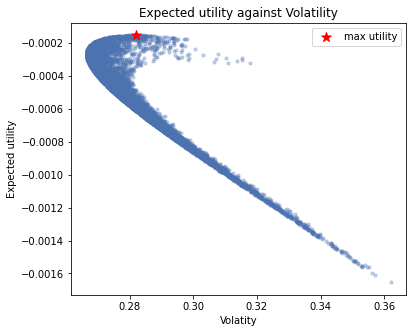

In [29]:
# Plotting  maximum expected utility portfolio using scatter()
plt.subplots(figsize=(6, 5))
plt.scatter(portfolios1['Volatility_opt'], portfolios1['Expected utility'],marker='o', s=10, alpha=0.3)
plt.title('Expected utility against Volatility')
plt.xlabel('Volatity')
plt.ylabel('Expected utility')
plt.scatter(max_util[1], max_util[2], color='r', marker='*', s=100,label='max utility')
plt.legend(loc='upper right')
plt.show()
           


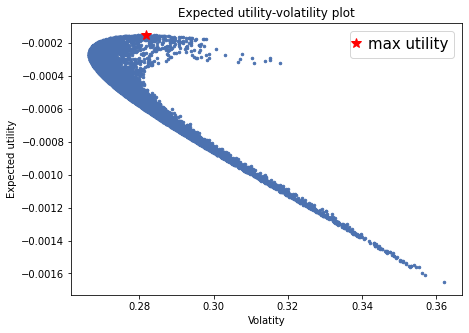

In [30]:
#plotting the maximum expected utility portfolio using plot()

#vilatility array
vol=np.array(p_vol1)
#expected utility array
util1=np.array(util)
plt.figure(figsize=(7,5))

##plot of expected utility against volatility
plt.plot(vol, util1,'.', markersize=5)
plt.title('Expected utility-volatility plot')
plt.xlabel('Volatity')
plt.ylabel('Expected utility')

##maximu expected utility portfolio
plt.plot(max_util[1], max_util[2], color='r', marker='*',  markersize=10,label='max utility')
plt.legend(handlelength=0,prop={'size': 15})
plt.savefig('max utility.pdf')
plt.show()

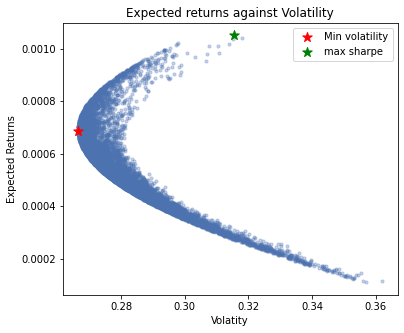

In [31]:
# Plotting optimal risky and minimum volatility portfolios using scatter()
plt.subplots(figsize=(6, 5))
plt.scatter(portfolios1['Volatility_opt'], portfolios1['Returns_opt'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port1[1], min_vol_port1[0], color='r', marker='*', s=100,label='Min volatility')
plt.scatter(optimal_risky_port1[1], optimal_risky_port1[0], color='g', marker='*', s=100,label='max sharpe')
plt.xlabel('Volatity')
plt.ylabel('Expected Returns')
plt.title('Expected returns against Volatility')

plt.legend(loc='upper right')
plt.show()

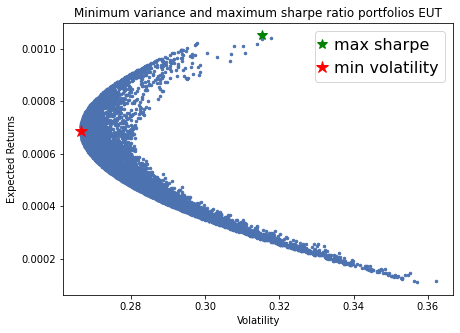

In [32]:
# Plotting optimal risky and minimum volatility portfolios using plt.plot()

##volatility and expected return arrays
vol=np.array(p_vol1)
ret=np.array(p_ret1)
util1=np.array(util)

plt.figure(figsize=(7,5))
plt.plot(vol,ret,'.',markersize=5)
plt.plot(optimal_risky_port1[1], optimal_risky_port1[0], color='g', marker='*',markersize=10,label='max sharpe')
plt.plot(min_vol_port1[1], min_vol_port1[0], color='r', marker='*', markersize=12, label='min volatility')
plt.xlabel('Volatility')
plt.ylabel('Expected Returns')
plt.title('Minimum variance and maximum sharpe ratio portfolios EUT')
plt.legend(handlelength=0,prop={'size': 16})
plt.savefig('Combined EUT.pdf')
plt.show()